# Progress Report for Data Analysis on Ethereum

### Link to GitHub Repository
https://github.com/cs418-fa24/project-check-in-team-2

## Project Introduction
In this project, we are analyzing Ethereum blockchain transaction data to investigate trends and insights related to recent transactions.
Our primary focus is to explore transaction patterns, fees, and the frequency of various transaction types to gain a deeper understanding of blockchain dynamics.

This analysis involves collecting recent transactions, cleaning the data, performing exploratory data analysis (EDA), and applying machine learning techniques to gain insights.

### Key Questions:
1. What patterns or trends can be identified in Ethereum transactions?
2. Are there specific metrics that can help predict Ethereum price movements?

## Changes to Project Scope
Since the initial proposal, we have made the following changes:
- **Scope Addition**: We have included a deeper analysis of transaction fees and patterns by block height to identify temporal patterns.
- **Scope Reduction**: We initially planned to analyze more historical data; however, we have limited the scope to recent blocks due to time constraints.

These adjustments will allow us to focus on recent trends and complete the analysis within the project timeline.

## Data Collection (Etherscan)
**Data Source:** The data is collected from [Etherscan.io](https://etherscan.io/txs) using Selenium, focusing on transaction hashes, block numbers, timestamps, addresses, and fees.

**Initial Observations:** The collected data includes transactional attributes that enable an analysis of transaction patterns, including frequency, transaction values, and fees.


Using Selenium, we automate the collection of transaction data, specifically gathering transaction hashes, block numbers, timestamps, addresses, and fees.

In [ ]:
!pip install selenium

In [ ]:
from bs4 import BeautifulSoup as bs
import requests as req
from selenium.webdriver.common.action_chains import ActionChains
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import math
import time
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import numpy as np
from math import sqrt
import random

We have disabled the data collection process by commenting it out, as the data has already been saved in a CSV file.

In [ ]:
# # Initialize WebDriver
# driver = webdriver.Chrome()

In [ ]:
# # Navigate to the blocks page to retrieve the latest block ID
# driver.get("https://etherscan.io/blocks")
# time.sleep(1)
# lastBlock = driver.find_element(by=By.XPATH, value="//*[@id=\"content\"]/section[2]/div[2]/div[2]/table/tbody/tr[1]/td[1]/a")
# lastBlockID = int(lastBlock.text)

In [ ]:
# # Generate URLs for the last 20 blocks
# blockURLs = []
# for blockID in range(lastBlockID, lastBlockID-20, -1):
#     blockURLs.append("https://etherscan.io/txs?block=" + str(blockID))

In [ ]:
# # Function to read each row's data in the transactions table
# def readRow(rowIndex):
#     row = {}
#     xPath = "//*[@id=\"ContentPlaceHolder1_divTransactions\"]/div[2]/table/tbody/tr[" + str(rowIndex) + "]/"
#     row["txnHash"] = driver.find_element(by=By.XPATH, value=xPath + "td[2]/div/span/a").text
#     row["method"] = driver.find_element(by=By.XPATH, value=xPath + "td[3]/span").text
#     row["block"] = driver.find_element(by=By.XPATH, value=xPath + "td[4]/a").text
#     row["age"] = driver.find_element(by=By.XPATH, value=xPath + "td[6]/span").text
#     row["from"] = driver.find_element(by=By.XPATH, value=xPath + "td[8]/div/a[1]").get_attribute("href").split("/")[-1]
#     row["to"] = driver.find_element(by=By.XPATH, value=xPath + "td[10]/div").find_elements(by=By.CSS_SELECTOR, value="a")[-1].get_attribute("data-clipboard-text")
#     row["value"] = driver.find_element(by=By.XPATH, value=xPath + "td[11]/span").text
#     row["txnFee"] = driver.find_element(by=By.XPATH, value=xPath + "td[12]").text
#     return row

*We used time.sleep(1) to avoid being blocked by the website.*

In [ ]:
# # Collect data for each block
# table = []
# for blockUrl in tqdm(blockURLs, desc="Collecting Data Blocks ("):
#     driver.get(blockUrl)
#     tranCount = int(driver.find_element(by=By.XPATH, value="//*[@id=\"ContentPlaceHolder1_divDataInfo\"]/div/div[1]/span").text.split(" ")[3])
#     pageCount = math.ceil(tranCount / 50)
#     for pageIndex in range(1, pageCount + 1):
#         url = blockUrl + "&p=" + str(pageIndex)
#         driver.get(url)
#         time.sleep(1)
#         rowBound = (tranCount - (pageCount - 1) * 50 + 1) if (pageIndex == pageCount) else 51
#         for rowIndex in range(1, rowBound):
#             table.append(readRow(rowIndex))
#     time.sleep(1)

*We're creating a CSV file to use later, so we don't have to run this code again.*

In [ ]:
# Convert to DataFrame and save to CSV
# dataFrame = pd.DataFrame(table)
# dataFrame.to_csv("DataFrame.csv", index=False)

# # Close the driver
# driver.quit()

## Data Cleaning
For this halfway report, we have completed the initial data cleaning steps:

**Incomplete Records Removal:** Rows with missing or incomplete data are removed to ensure a consistent dataset.

**Standardizing Columns:** Timestamps are standardized, and columns that are not useful for analysis (e.g., transaction hash, method, age, from, to) are dropped to streamline the dataset.

**Outliers Removal:** Outliers are identified and removed based on values outside 3 standard deviations from the mean, assuming a normal distribution.


*Removing columns that we do not need to analyze from the DataFrame.*

In [ ]:
cleanedDataFrame = pd.read_csv("DataFrame.csv")
cleanedDataFrame = cleanedDataFrame.drop(["txnHash", "method", "age", "from", "to"], axis=1)

*We are changing the data type of the 'Value' and 'txnFee' columns to float.*

In [ ]:
cleanedDataFrame["txnFee"] = cleanedDataFrame["txnFee"].apply(lambda x: float(x))
pattern = r"(\d+\.?\d*)"
cleanedDataFrame["value"] = cleanedDataFrame["value"].apply(lambda x: float(re.findall(pattern, x)[0]))

*We are removing outliers by identifying and excluding data points that fall outside the range of 3 standard deviations from the mean, based on the assumption that the dataset follows a normal distribution.*

In [ ]:
threshold = 3
columnsForProcess = ['value', 'txnFee']
outliersMask = ~((cleanedDataFrame[columnsForProcess] - cleanedDataFrame[columnsForProcess].mean()).abs() > threshold * cleanedDataFrame[columnsForProcess].std()).any(axis=1)
cleanedDataFrameWithoutOutlier = cleanedDataFrame[outliersMask]

 **Basic Statistics**

- **Mean and Standard Deviation:** The mean and standard deviation for 'value' and 'txnFee' columns give insight into the central tendency and variability of transaction values and fees after outlier removal.
- **Histogram Binning Strategy:** Using the square root of the data size as the bin count is a good approach for balancing visual interpretability and detail without overfitting to outliers.

In [ ]:
valueMean = cleanedDataFrameWithoutOutlier['value'].mean()
valueStd = cleanedDataFrameWithoutOutlier['value'].std()
feeMean = cleanedDataFrameWithoutOutlier['txnFee'].mean()
feeStd = cleanedDataFrameWithoutOutlier['txnFee'].std()
print("Value Column:")
print("Mean:", valueMean)
print("Standard Deviation:", valueStd)
print("\ntxnFee Column:")
print("Mean:", feeMean)
print("Standard Deviation:", feeStd)

Value Column:
Mean: 0.2901379006318644
Standard Deviation: 2.4571333143219043

txnFee Column:
Mean: 0.0007800431423728814
Standard Deviation: 0.0011140786725361243


##Data Visualization & Distribution Analysis
We are using the method of setting the bin size to the square root of the dataset size to achieve a balanced number of optimally sized bins that provide a robust and visually interpretable representation of the data distribution, while mitigating the impact of outliers.

Histograms of Value and Transaction Fees:

- The histogram for transaction values allows an assessment of the spread and frequency of different transaction sizes.
- Observing the histogram post-outlier removal and with zero-value transactions filtered out helps highlight significant transaction patterns, showing a skewed distribution of transaction values and fees.



<ipython-input-58-7fdd5a345ce4>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cleanedDataFrameWithoutOutlier["value"],bins=binValue)


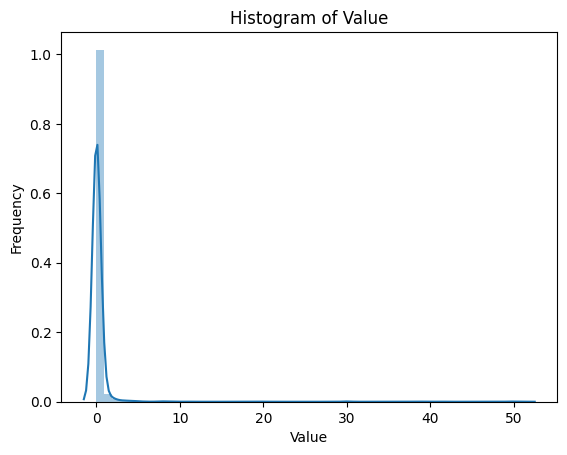

In [ ]:
binValue=int(sqrt(len(cleanedDataFrameWithoutOutlier["value"])))
sns.distplot(cleanedDataFrameWithoutOutlier["value"],bins=binValue)
plt.title('Histogram of Value')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

*Removing Transactions with zero value:*

In [ ]:
removedZeroesDF = cleanedDataFrameWithoutOutlier["value"]
removedZeroesDF = removedZeroesDF[removedZeroesDF != 0]
removedZeroesDF = removedZeroesDF.reset_index()

<ipython-input-60-1ce77bb61adc>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(removedZeroesDF["value"],bins=binValue)


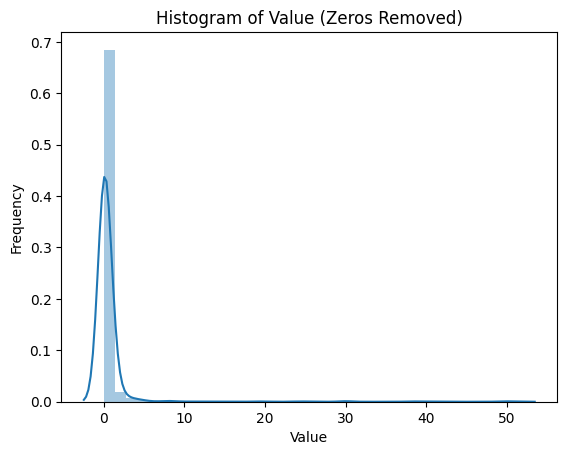

In [ ]:
binValue=int(sqrt(len(removedZeroesDF["value"])))
sns.distplot(removedZeroesDF["value"],bins=binValue)
plt.title('Histogram of Value (Zeros Removed)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

<ipython-input-61-428dd2611807>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cleanedDataFrameWithoutOutlier["txnFee"],bins=binValue)


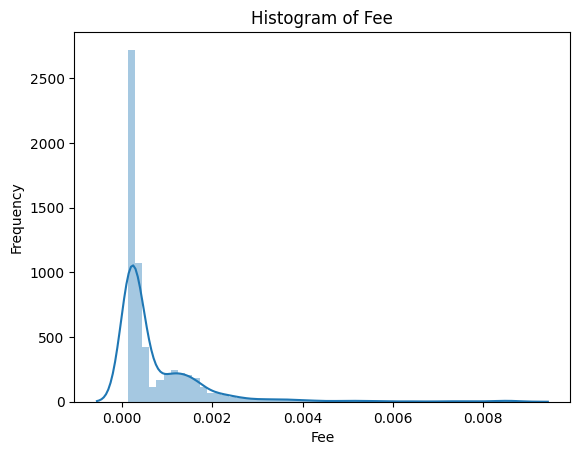

In [ ]:
binValue=int(sqrt(len(cleanedDataFrameWithoutOutlier["txnFee"])))
sns.distplot(cleanedDataFrameWithoutOutlier["txnFee"],bins=binValue)
plt.title('Histogram of Fee')
plt.xlabel('Fee')
plt.ylabel('Frequency')
plt.show()

**Violin and Box Plots for Transaction Value and Fees:**

**Violin Plot:** Provides a detailed view of the distribution and density of transaction values and fees. It helps in identifying whether the data follows a normal distribution or has skewness, and shows where data clusters.

**Box Plot:** Highlights central values, variability, and outliers within the range of transaction values and fees. It visually emphasizes extreme values and spread for further analysis.

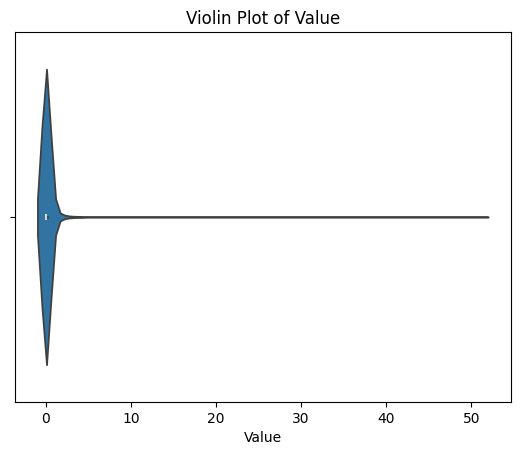

In [ ]:
sns.violinplot(x=cleanedDataFrameWithoutOutlier["value"])
plt.xlabel("Value")
plt.title("Violin Plot of Value")
plt.show()

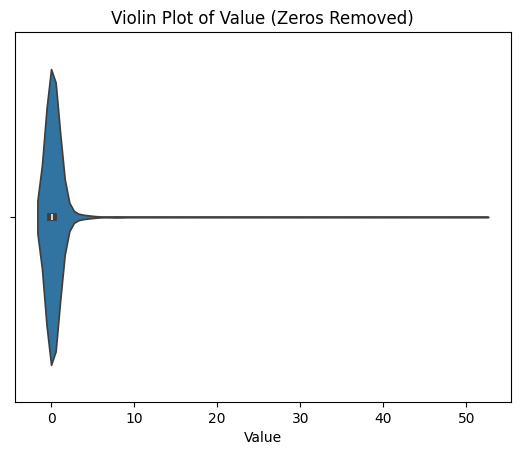

In [ ]:
sns.violinplot(x=removedZeroesDF["value"])
plt.xlabel("Value")
plt.title("Violin Plot of Value (Zeros Removed)")
plt.show()

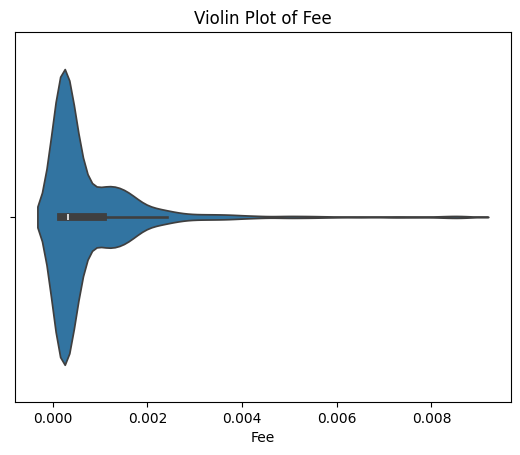

In [ ]:
sns.violinplot(x=cleanedDataFrameWithoutOutlier["txnFee"])
plt.xlabel("Fee")
plt.title("Violin Plot of Fee")
plt.show()

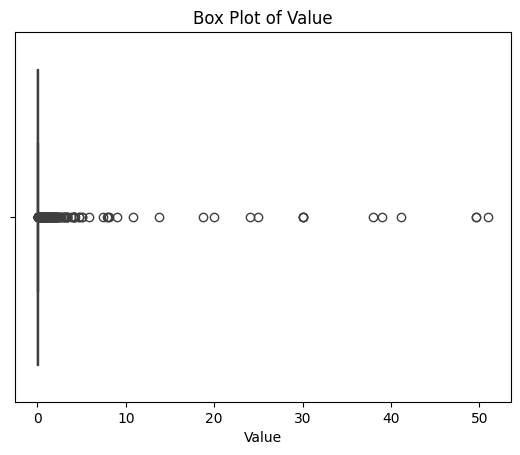

In [ ]:
sns.boxplot(x=cleanedDataFrameWithoutOutlier["value"])
plt.xlabel("Value")
plt.title("Box Plot of Value")
plt.show()

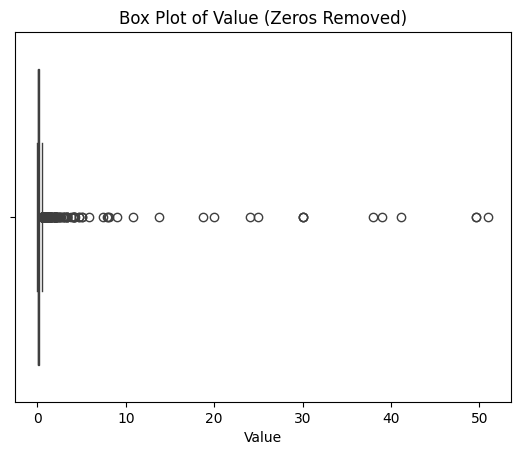

In [ ]:
sns.boxplot(x=removedZeroesDF["value"])
plt.xlabel("Value")
plt.title("Box Plot of Value (Zeros Removed)")
plt.show()

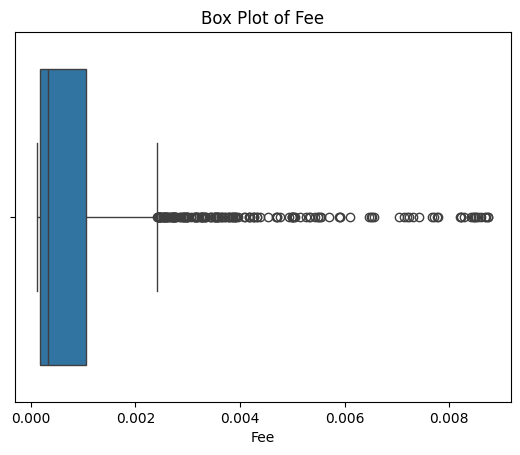

In [ ]:
sns.boxplot(x=cleanedDataFrameWithoutOutlier["txnFee"])
plt.xlabel("Fee")
plt.title("Box Plot of Fee")
plt.show()

## Exploratory Data Analysis (EDA)
Our EDA focuses on understanding the dataset structure and identifying key characteristics related to transaction fees and methods. We included visualizations such as histograms and line plots to illustrate these trends and distributions.

- **Transaction Fee Distribution:** A histogram with KDE (kernel density estimate) visualizes the spread of transaction fees, highlighting typical values and outliers. Analyzing the distribution of transaction fees helps us to detect patterns, outliers, and potential discrepancies in transaction costs.

- **Block Number Correlation:** A scatter plot explores the relationship between transaction fees and block numbers, allowing us to observe if fees vary significantly by block.

- **Average Transaction Fee per Block:** A line plot shows the trend of average transaction fees over blocks, which can help identify any temporal trends in transaction costs.

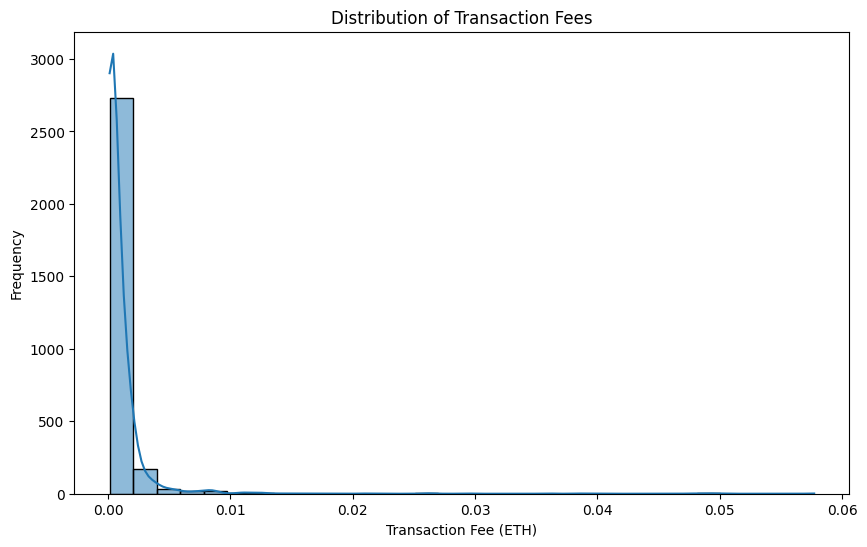

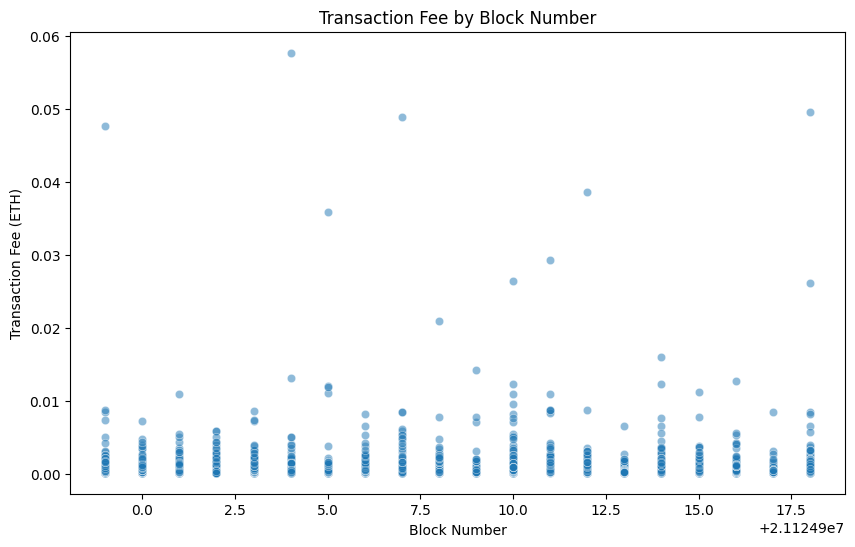

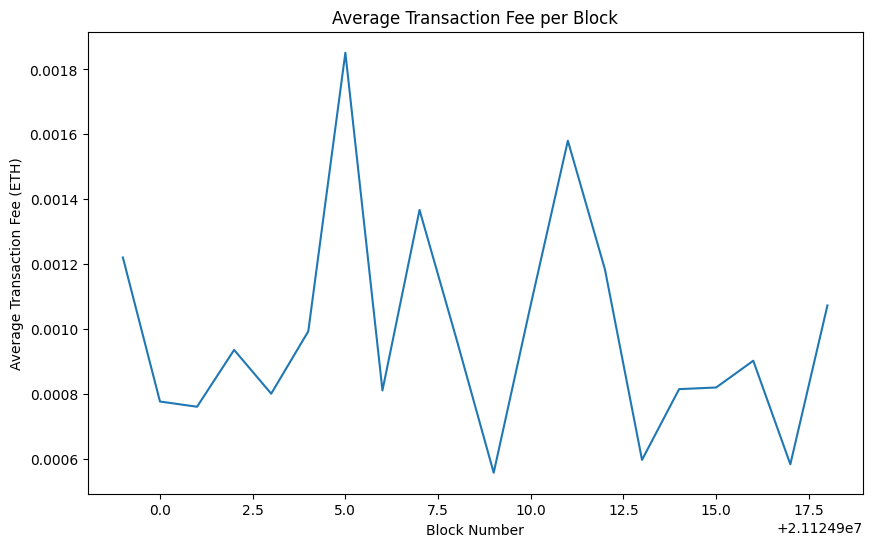

In [ ]:
cleanedDataFrame = pd.read_csv("DataFrame.csv")
cleanedDataFrame = cleanedDataFrame.drop(["txnHash", "age", "from", "to"], axis=1)

# Convert 'txnFee' and 'value' columns to numeric types, handling any potential formatting issues
cleanedDataFrame["txnFee"] = cleanedDataFrame["txnFee"].apply(lambda x: float(x))
pattern = r"(\d+\.?\d*)"
cleanedDataFrame["value"] = cleanedDataFrame["value"].apply(lambda x: float(re.findall(pattern, x)[0]))

# 1. Transaction Fee Distribution
plt.figure(figsize=(10, 6))
sns.histplot(cleanedDataFrame["txnFee"], bins=30, kde=True)
plt.title("Distribution of Transaction Fees")
plt.xlabel("Transaction Fee (ETH)")
plt.ylabel("Frequency")
plt.show()

# 2. Block Number Correlation with Transaction Fee
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleanedDataFrame, x="block", y="txnFee", alpha=0.5)
plt.title("Transaction Fee by Block Number")
plt.xlabel("Block Number")
plt.ylabel("Transaction Fee (ETH)")
plt.show()

# 3. Line plot of average transaction fee per block
# Group by block and calculate the mean transaction fee for each block
block_fee_avg = cleanedDataFrame.groupby("block")["txnFee"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=block_fee_avg, x="block", y="txnFee")
plt.title("Average Transaction Fee per Block")
plt.xlabel("Block Number")
plt.ylabel("Average Transaction Fee (ETH)")
plt.show()

We perform an initial exploration of the dataset by calculating descriptive statistics for each column and visualizing the distribution and relationships of numeric features. It first creates a summary table, including general information (like column names, data types, and null values) for all columns, and computes mean, standard deviation, minimum, and maximum values for numeric columns. Then, it visualizes the numeric data distributions using histograms and highlights correlations between features with a heatmap, aiding in identifying patterns and relationships within the data.

First Few Rows of the Data:
             method     block     value    txnFee
0          Transfer  21124918  0.092679  0.000126
1       Commit Blob  21124918  0.000000  0.000240
2     Propose Block  21124918  0.000000  0.001379
3          Transfer  21124918  1.000000  0.000158
4  Earn Preparation  21124918  0.000000  0.003000

EDA Summary:
       Column Names  Null Values  Unique Values Data Types          Mean  \
method       method            0            293     object           NaN   
block         block            0             20      int64  2.112491e+07   
value         value            0           1207    float64  1.451123e+00   
txnFee       txnFee            0           2155    float64  9.619414e-04   

        Standard Deviation           Min           Max  
method                 NaN           NaN           NaN  
block             5.803496  2.112490e+07  2.112492e+07  
value            20.199170  0.000000e+00  7.170000e+02  
txnFee            0.002638  1.262600e-04  5.77189

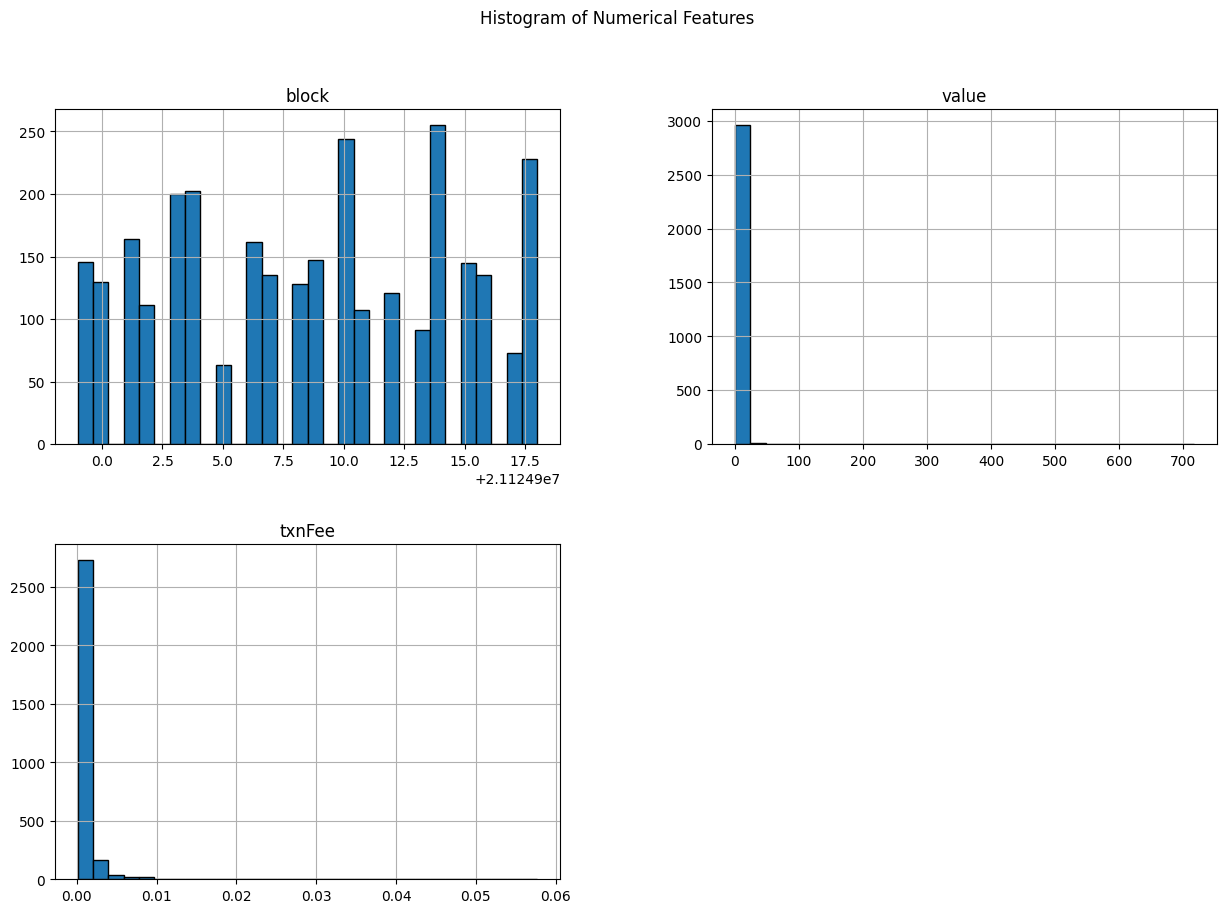

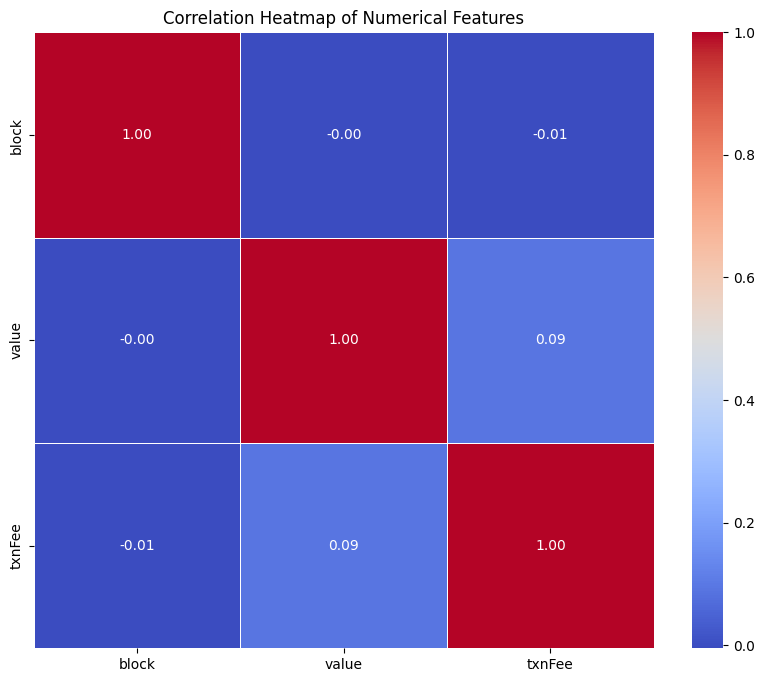

In [ ]:
numeric_cols = cleanedDataFrame.select_dtypes(include=['float64', 'int64']).columns

eda_summary = pd.DataFrame({
    "Column Names": cleanedDataFrame.columns,
    "Null Values": cleanedDataFrame.isnull().sum(),
    "Unique Values": cleanedDataFrame.nunique(),
    "Data Types": cleanedDataFrame.dtypes,
})

# Add mean, standard deviation, min, and max
eda_summary_numeric = pd.DataFrame({
    "Mean": cleanedDataFrame[numeric_cols].mean(),
    "Standard Deviation": cleanedDataFrame[numeric_cols].std(),
    "Min": cleanedDataFrame[numeric_cols].min(),
    "Max": cleanedDataFrame[numeric_cols].max(),
})

# Combine both summaries
eda_summary = pd.concat([eda_summary, eda_summary_numeric], axis=1)


print("First Few Rows of the Data:")
print(cleanedDataFrame.head())
print("\nEDA Summary:")
print(eda_summary)



# 1. Histogram of Numerical Features
cleanedDataFrame[numeric_cols].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histogram of Numerical Features')
plt.show()

# 2. Correlation Heatmap for Numerical Features
plt.figure(figsize=(10, 8))
sns.heatmap(cleanedDataFrame[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Hypothesis Testing Visualization
We tested the hypothesis: **“Higher gas fees indicate higher transaction volume and network congestion.”**
- **Visualization**: We calculate the average gas fee and transaction volume for each block, where transaction_volume represents the count of transactions per block. A scatter plot showing the relationship between transaction volume and average gas fees during peak and low-traffic periods. The plot visualizes the relationship between transaction volume and average gas fees, with each point representing a block. This helps identify patterns that may suggest higher fees during periods of higher transaction volume. We use the top 25% as the "peak" threshold and the bottom 25% as the "low" threshold for transaction volume.

- **Interpretation**: In the plot, there are indeed some high-transaction-volume blocks (categorized as "Peak") with higher gas fees, which aligns with the hypothesis. However, there are also cases where high gas fees are observed in "Low" transaction volume periods, and several "Normal" periods display a wide range of gas fees with no clear linear relationship. This suggests that while transaction volume might influence gas fees, other factors—such as network congestion, block demand, or fee structure changes—may also play significant roles. Further statistical analysis or additional data might be needed to determine causation.



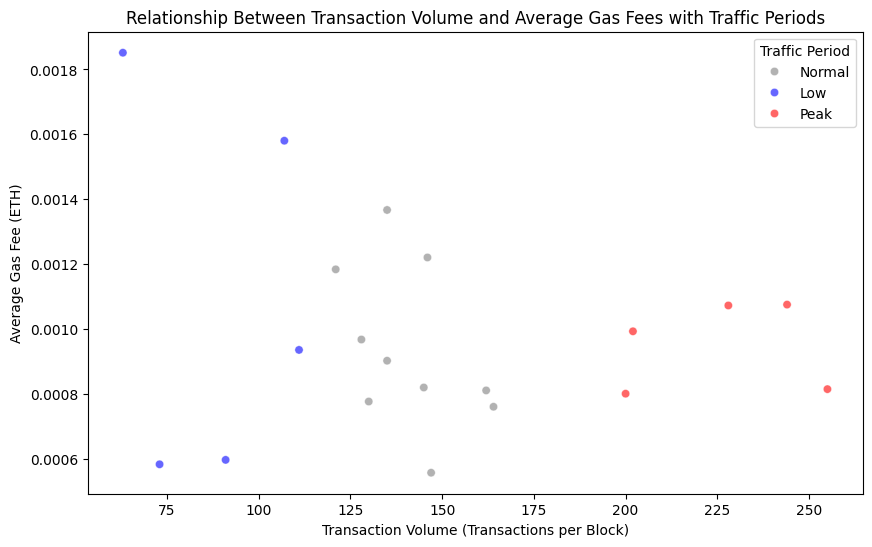

In [ ]:
block_stats = cleanedDataFrame.groupby('block').agg(
    avg_gas_fee=('txnFee', 'mean'),   # Average transaction fee as a proxy for gas fee
    transaction_volume=('txnFee', 'size')  # Transaction count per block as volume
).reset_index()

volume_threshold_high = block_stats['transaction_volume'].quantile(0.75)
volume_threshold_low = block_stats['transaction_volume'].quantile(0.25)

# Categorize blocks based on transaction volume
block_stats['traffic_period'] = np.where(
    block_stats['transaction_volume'] >= volume_threshold_high, 'Peak',
    np.where(block_stats['transaction_volume'] <= volume_threshold_low, 'Low', 'Normal')
)

# Visualization: Scatter plot with different colors for peak and low-traffic periods
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=block_stats, x='transaction_volume', y='avg_gas_fee', hue='traffic_period',
    palette={'Peak': 'red', 'Low': 'blue', 'Normal': 'gray'}, alpha=0.6
)
plt.title("Relationship Between Transaction Volume and Average Gas Fees with Traffic Periods")
plt.xlabel("Transaction Volume (Transactions per Block)")
plt.ylabel("Average Gas Fee (ETH)")
plt.legend(title="Traffic Period")
plt.show()

## Initial Machine Learning Analysis
We have started preliminary ML analysis:

- Feature Engineering: Incorporate additional relevant features like average transaction value, and average gas price. This should provide more context and potentially improve the model's predictive power. Create new features such as:
 - Rolling Averages: Rolling averages of transaction volume or fees over different window sizes, capturing trends and recent patterns.
 - Transaction Value Ratios: Ratios between transaction volume and average transaction value or fee, which could highlight spikes or abnormalities.

- Different Models: Test multiple regression models beyond linear regression, such as:
 - Random Forest Regressor: A robust model that can capture nonlinear relationships.
 - Gradient Boosting Regressor (e.g., XGBoost): Often performs well on tabular data.
 - Lasso or Ridge Regression: These can regularize the model, preventing overfitting on a small dataset.

- Hyperparameter Tuning: Use cross-validation to tune hyperparameters for each model, aiming to optimize performance metrics.

- Evaluation Metrics: Besides Mean Absolute Error (MAE) and Mean Squared Error (MSE), we use Root Mean Squared Error (RMSE) and R-squared (R²) to better interpret model accuracy.



Model Performance Comparison:
                         MAE          MSE       RMSE        R²
Linear Regression  12.897428   297.946121  17.261116  0.897390
Ridge Regression   16.724501   355.498103  18.854657  0.877570
Lasso Regression   16.507441   355.025766  18.842127  0.877733
Random Forest      30.807500  1234.710025  35.138441  0.574779
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Model Performance:
MAE: 30.318749999999994
RMSE: 34.822513640603255
R²: 0.5823905099119655


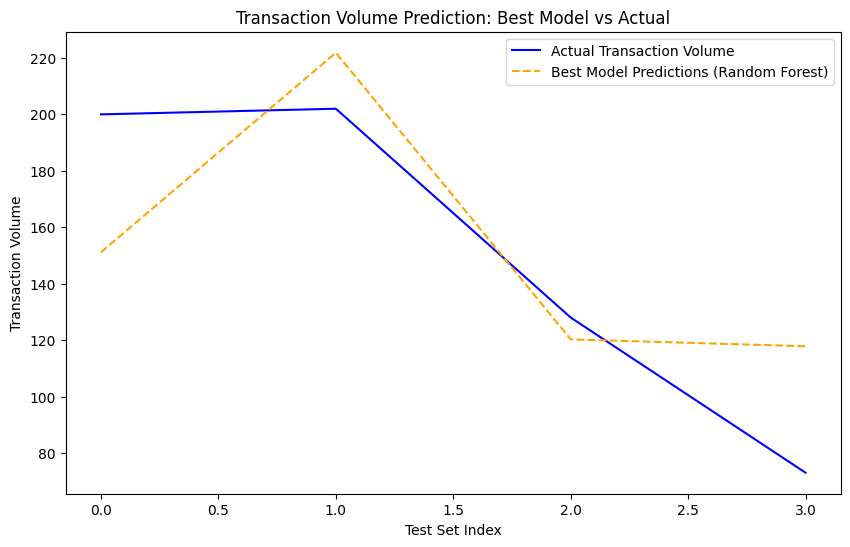

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Feature Engineering

block_stats['rolling_avg_volume'] = block_stats['transaction_volume'].rolling(window=5).mean()
block_stats['volume_to_fee_ratio'] = block_stats['transaction_volume'] / (block_stats['avg_gas_fee'] + 1e-9)  # Avoid division by zero
block_stats.dropna(inplace=True)
features = block_stats[['avg_gas_fee', 'block', 'rolling_avg_volume', 'volume_to_fee_ratio']]
target = block_stats['transaction_volume']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 2. Model Training and Comparison


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df)

# 3. Hyperparameter Tuning

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
print("Best Parameters for Random Forest:", grid_search.best_params_)

# 4. Evaluate the best model on test set
y_best_pred = best_rf_model.predict(X_test)
best_mae = mean_absolute_error(y_test, y_best_pred)
best_rmse = np.sqrt(mean_squared_error(y_test, y_best_pred))
best_r2 = r2_score(y_test, y_best_pred)

print("Best Random Forest Model Performance:")
print("MAE:", best_mae)
print("RMSE:", best_rmse)
print("R²:", best_r2)

# 5. Visualization

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual Transaction Volume", color="blue")
plt.plot(y_best_pred, label="Best Model Predictions (Random Forest)", color="orange", linestyle='--')
plt.legend()
plt.title("Transaction Volume Prediction: Best Model vs Actual")
plt.xlabel("Test Set Index")
plt.ylabel("Transaction Volume")
plt.show()

The plot suggests a significant discrepancy between the actual transaction volume and the model’s predictions. The "Actual Transaction Volume" (blue line) is much higher and shows a clear upward trend, while the "Best Model Predictions (Random Forest)" (orange dashed line) remains relatively flat and much lower.

This result indicates that the model is not accurately capturing the patterns in transaction volume, and we need to perform further analysis.

## Reflection
- **Hardest part:** The hardest part so far has been obtaining clean, meaningful data from the Ethereum blockchain and effectively preprocessing it. Blockchain data is complex, with many attributes, and can be noisy or contain outliers. Additionally, data collection from sources like Etherscan involves web scraping or API access, which can be slow and sometimes rate-limited. Feature engineering has also been challenging, as we need to identify which transaction attributes are most predictive of volume patterns without overwhelming the model with too many irrelevant features.

- **Initial Insights:** Our initial insights suggest that transaction volume correlates with certain network metrics, such as gas fees, but the relationship is not straightforward. Volume tends to increase during periods of high activity, which leads to congestion and higher gas fees. However, gas fees alone do not entirely explain transaction volume, indicating that other factors, such as transaction type or external market conditions, may also play significant roles. We are beginning to see potential value in time-based features, as transaction patterns vary by time of day and day of the week.

- **Concrete Results:** We have some preliminary results, such as baseline predictions using a moving average and initial predictions using linear and random forest regression models. However, these results show only slight improvement over the baseline and still leave a large gap compared to actual transaction volumes. This suggests that our model is not yet accurate enough and requires further refinement.

- **Current Problems:** We are considering additional data collection methods (e.g., API). Also, the main issues going forward are improving model accuracy and understanding the complex relationships within blockchain data. We need to refine our feature engineering to capture more relevant transaction patterns and potentially add more data sources or external variables that could help. Additionally, we may need to experiment with different models or advanced techniques, such as time-series analysis, to better capture trends over time. Another challenge is handling data processing efficiently, as large blockchain datasets can strain resources, requiring optimized code and data handling methods.

- **On Track:** We are making progress, but there are areas where we need to allocate more time to stay on track. Specifically, more effort is required in refining our feature engineering and trying different modeling approaches to improve prediction accuracy.

- **Project Worth:** Yes, it is worth proceeding with the project. Our initial data exploration indicates potential patterns in transaction volume and fees that could be valuable for understanding network congestion and blockchain dynamics. The insights gained could be useful for Ethereum network analysis, providing practical insights for both blockchain researchers and participants.

##Project Work Division and Responsibilities
###1. Data Collection and Web Scraping
#### Team Members: Nastaran Darabi & Shreyash Kadam & Sanmitha Shetty
**Responsibilities:**
* Write scripts to scrape transaction data from Etherscan.
* Handle pagination and ensure data completeness.
* Save raw data to a format suitable for cleaning and exploration (e.g., CSV or JSON).
* Document the scraping process, handling rate limits, and data collection steps.

###2. Data Cleaning and Preprocessing
#### Team Members:  Frank Wang & Victor Escudero & Dhiraj Shelke
**Responsibilities:**
* Clean the collected data by removing duplicates, handling null values, and standardizing formats.
* Identify any outliers or anomalies in the data.
* Prepare the dataset for analysis, ensuring all columns and data types are ready for exploratory data analysis.
* Document cleaning decisions and any assumptions made during preprocessing.

###3. Exploratory Data Analysis (EDA) and Data Sampling
#### Team Members: Frank Wang & Victor Escudero & Dhiraj Shelke
**Responsibilities:**
* Conduct an initial data exploration, including basic descriptive statistics.
* Create data samples to ensure a representative dataset for analysis.
* Visualize key findings (e.g., transaction distribution, transaction size, frequency over time).
* Document observations and initial insights from the EDA.

###4. Machine Learning Application
#### Team Members: Nastaran Darabi & Shreyash Kadam & Sanmitha Shetty
**Responsibilities:**
* Select a suitable machine learning model (e.g., regression, classification, clustering) based on the data and project goals.
* Implement the model and train it on the cleaned Ethereum transaction data.
* Evaluate the model’s performance using relevant metrics (e.g., accuracy, F1 score, RMSE).
* Document model choice, training process, and evaluation results, explaining their significance to the overall analysis.

###5. Data Visualization and Reporting
#### Team Members: All team members
**Responsibilities:**
* Design visualizations to highlight key insights from both the EDA and the machine learning model.
* Summarize analysis findings in a report with visuals, including EDA and ML results.
* Ensure that all visualizations are clear, relevant, and well-labeled.
* Document visualization decisions and report on the project findings.

###6. Conclusion, Final Presentation, and Project Documentation
#### Team Members: All team members
**Responsibilities:**
* Summarize final findings, including insights from the machine learning model and overall analysis.
* Prepare a final presentation covering methodology, results, ML insights, and key takeaways.
* Organize and finalize all project documentation, including code comments, README, and setup instructions.
* Ensure all documentation is well-structured and ready for submission or presentation.

## Next Steps

In the next month, we plan to:

- Enhance Feature Engineering: We’ll explore incorporating external factors, such as Ethereum market data, to see if they improve prediction accuracy.

- Experiment with Advanced Models: We will try additional machine learning models, including Gradient Boosting (e.g., XGBoost) and time-series models like ARIMA or LSTM , to capture complex relationships and trends more effectively.

- Optimize Data Handling: Since blockchain data can be extensive, we’ll work on optimizing our data processing pipeline to handle larger datasets efficiently, ensuring our code is scalable and responsive.